# Practice Lab: Advice for Applying Machine Learning
In this lab, you will explore techniques to evaluate and improve your machine learning models.

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Evaluating a Learning Algorithm (Polynomial Regression)](#2)
  - [ 2.1 Splitting your data set](#2.1)
  - [ 2.2 Error calculation for model evaluation, linear regression](#2.2)
    - [ Exercise 1](#ex01)
  - [ 2.3 Compare performance on training and test data](#2.3)
- [ 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> ](#3)
  - [ 3.1 Plot Train, Cross-Validation, Test](#3.1)
  - [ 3.2 Finding the optimal degree](#3.2)
  - [ 3.3 Tuning Regularization.](#3.3)
  - [ 3.4 Getting more data: Increasing Training Set Size (m)](#3.4)
- [ 4 - Evaluating a Learning Algorithm (Neural Network)](#4)
  - [ 4.1 Data Set](#4.1)
  - [ 4.2 Evaluating categorical model by calculating classification error](#4.2)
    - [ Exercise 2](#ex02)
- [ 5 - Model Complexity](#5)
  - [ Exercise 3](#ex03)
  - [ 5.1 Simple model](#5.1)
    - [ Exercise 4](#ex04)
- [ 6 - Regularization](#6)
  - [ Exercise 5](#ex05)
- [ 7 - Iterate to find optimal regularization value](#7)
  - [ 7.1 Test](#7.1)


<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [scikitlearn](https://scikit-learn.org/stable/) is a basic library for data mining
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

C:\Users\joshu\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<a name="2"></a>
## 2 - Evaluating a Learning Algorithm (Polynomial Regression)

<img align="Right" src="./images/C2_W3_TrainingVsNew.png"  style=" width:350px; padding: 10px 20px ; "> Let's say you have created a machine learning model and you find it *fits* your training data very well. You're done? Not quite. The goal of creating the model was to be able to predict values for <span style="color:blue">*new* </span> examples. 

How can you test your model's performance on new data before deploying it?   
The answer has two parts:
* Split your original data set into "Training" and "Test" sets. 
    * Use the training data to fit the parameters of the model
    * Use the test data to evaluate the model on *new* data
* Develop an error function to evaluate your model.

<a name="2.1"></a>
### 2.1 Splitting your data set
Lectures advised reserving 20-40% of your data set for testing. Let's use an `sklearn` function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to perform the split. Double-check the shapes after running the following cell.

In [2]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


#### 2.1.1 Plot Train, Test sets
You can see below the data points that will be part of training (in red) are intermixed with those that the model is not trained on (test). This particular data set is a quadratic function with noise added. The "ideal" curve is shown for reference.

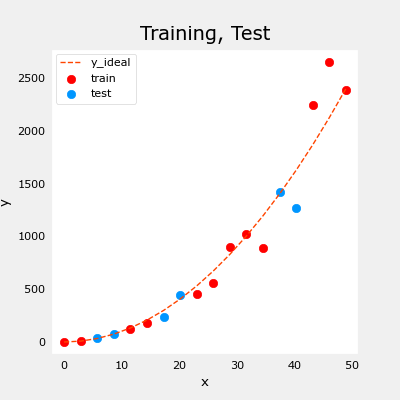

In [3]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="2.2"></a>
### 2.2 Error calculation for model evaluation, linear regression
When *evaluating* a linear regression model, you average the squared error difference of the predicted values and the target values.

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

<a name="ex01"></a>
### Exercise 1

Below, create a function to evaluate the error on a data set for a linear regression model.

In [14]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
    ### START CODE HERE ### 
        err_i = ((yhat[i]-y[i])**2) 
        err += err_i 
    err = err/(2*m) 
    ### END CODE HERE ### 
    return(err)

In [15]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)   
# END UNIT TEST

 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

    
```python
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
    err = err / (2*m)                    
    return(err)
``` 

<a name="2.3"></a>
### 2.3 Compare performance on training and test data
Let's build a high degree polynomial model to minimize training error. This will use the linear_regression functions from `sklearn`. The code is in the imported utility file if you would like to see the details. The steps below are:
* create and fit the model. ('fit' is another name for training or running gradient descent).
* compute the error on the training data.
* compute the error on the test data.

In [16]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

The computed error on the training set is substantially less than that of the test set. 

In [17]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


The following plot shows why this is. The model fits the training data very well. To do so, it has created a complex function. The test data was not part of the training and the model does a poor job of predicting on this data.  
This model would be described as 1) is overfitting, 2) has high variance 3) 'generalizes' poorly.

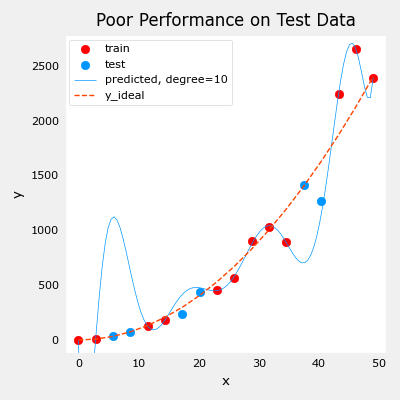

In [18]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The test set error shows this model will not work well on new data. If you use the test error to guide improvements in the model, then the model will perform well on the test data... but the test data was meant to represent *new* data.
You need yet another set of data to test new data performance.

The proposal made during lecture is to separate data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |


Let's generate three data sets below. We'll once again use `train_test_split` from `sklearn` but will call it twice to get three splits:

In [19]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


<a name="3"></a>
## 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> 
 Above, it was clear the degree of the polynomial model was too high. How can you choose a good value? It turns out, as shown in the diagram, the training and cross-validation performance can provide guidance. By trying a range of degree values, the training and cross-validation performance can be evaluated. As the degree becomes too large, the cross-validation performance will start to degrade relative to the training performance. Let's try this on our example.

<a name="3.1"></a>
### 3.1 Plot Train, Cross-Validation, Test
You can see below the datapoints that will be part of training (in red) are intermixed with those that the model is not trained on (test and cv).

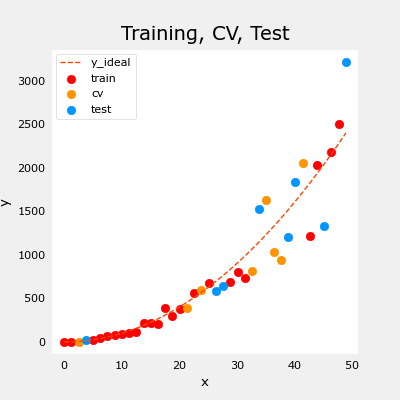

In [20]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="3.2"></a>
### 3.2 Finding the optimal degree
In previous labs, you found that you could create a model capable of fitting complex curves by utilizing a polynomial (See Course1, Week2 Feature Engineering and Polynomial Regression Lab).  Further, you demonstrated that by increasing the *degree* of the polynomial, you could *create* overfitting. (See Course 1, Week3, Over-Fitting Lab). Let's use that knowledge here to test our ability to tell the difference between over-fitting and under-fitting.

Let's train the model repeatedly, increasing the degree of the polynomial each iteration. Here, we're going to use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) linear regression model for speed and simplicity.

In [21]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

<font size="4">Let's plot the result:</font>

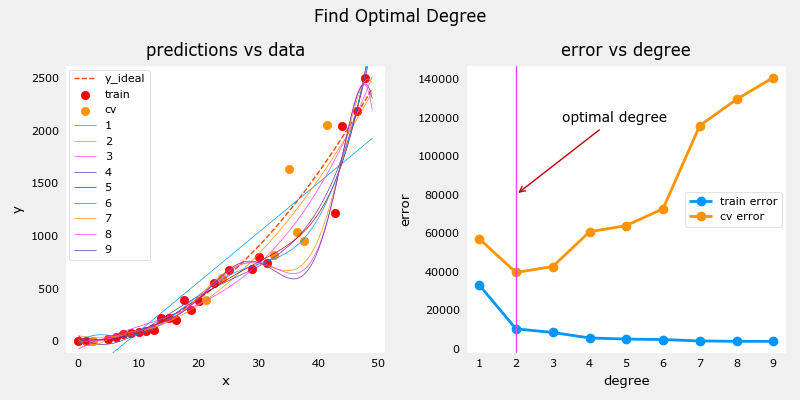

In [22]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

The plot above demonstrates that separating data into two groups, data the model is trained on and data the model has not been trained on, can be used to determine if the model is underfitting or overfitting. In our example, we created a variety of models varying from underfitting to overfitting by increasing the degree of the polynomial used. 
- On the left plot, the solid lines represent the predictions from these models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point. 
- on the right:
    - the error on the trained data (blue) decreases as the model complexity increases as expected
    - the error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to *generalize*).     
    
It's worth noting that the curves in these examples as not as smooth as one might draw for a lecture. It's clear the specific data points assigned to each group can change your results significantly. The general trend is what is important.

<a name="3.3"></a>
### 3.3 Tuning Regularization.
In previous labs, you have utilized *regularization* to reduce overfitting. Similar to degree, one can use the same methodology to tune the regularization parameter lambda ($\lambda$).

Let's demonstrate this by starting with a high degree polynomial and varying the regularization parameter.

In [23]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

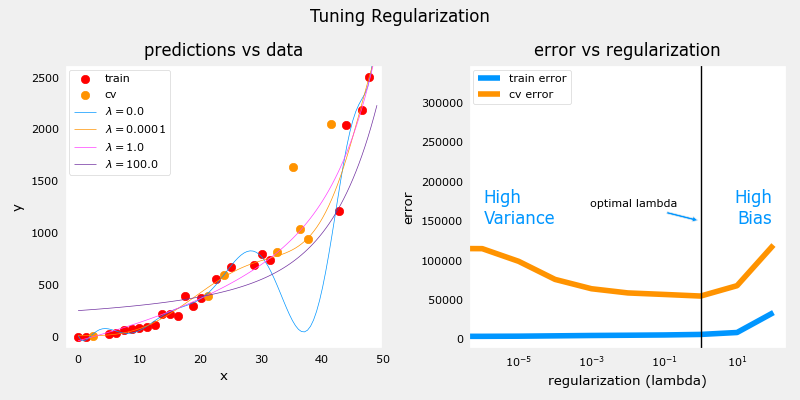

In [24]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 

<a name="3.4"></a>
### 3.4 Getting more data: Increasing Training Set Size (m)
When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

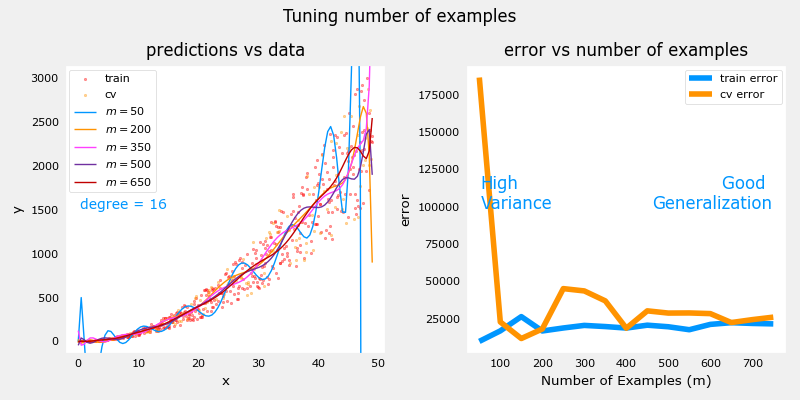

In [25]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of $m$ is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values. Note that the curves are not as smooth as one might see in a lecture. That is to be expected. The trend remains clear: more data improves generalization. 

> Note that adding more examples when the model has high bias (underfitting) does not improve performance.


<a name="4"></a>
## 4 - Evaluating a Learning Algorithm (Neural Network)
Above, you tuned aspects of a polynomial regression model. Here, you will work with a neural network model. Let's start by creating a classification data set. 

<a name="4.1"></a>
### 4.1 Data Set
Run the cell below to generate a data set and split it into training, cross-validation (CV) and test sets. In this example, we're increasing the percentage of cross-validation data points for emphasis.  

In [26]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


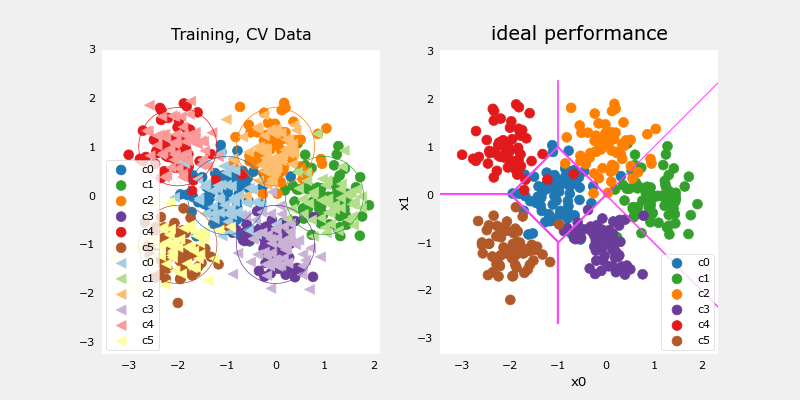

In [27]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?  
On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.

<a name="4.2"></a>
### 4.2 Evaluating categorical model by calculating classification error
The evaluation function for categorical models used here is simply the fraction of incorrect predictions:  
$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

<a name="ex02"></a>
### Exercise 2

Below, complete the routine to calculate classification error. Note, in this lab, target values are the index of the category and are not [one-hot encoded](https://en.wikipedia.org/wiki/One-hot).

In [29]:
# UNQ_C2
# GRADED CELL: eval_cat_err
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
    ### START CODE HERE ### 
        if yhat[i] != y[i]:
            incorrect += 1 
    cerr = incorrect/m
    ### END CODE HERE ### 
    
    return(cerr)

In [30]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST
# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.
 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    return(cerr)                                    
``` 

<a name="5"></a>
## 5 - Model Complexity
Below, you will build two models. A complex model and a simple model. You will evaluate the models to determine if they are likely to overfit or underfit.

###  5.1 Complex model

<a name="ex03"></a>
### Exercise 3
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation
* Dense layer with 40 units, relu activation
* Dense layer with 6 units and a linear activation (not softmax)  
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [31]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ### 
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")
        ### END CODE HERE ### 

    ], name="Complex"
)
model.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    ### END CODE HERE ### 
)

In [32]:
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3586  
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.4303
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3646
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2731
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2358
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2205
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.2063
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2013
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1978
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1939
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1933
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1898
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1886
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1878
Epoch 15/1000
13/13 ━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1259
Epoch 80/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1200
Epoch 81/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1222
Epoch 82/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1354
Epoch 83/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1294
Epoch 84/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1238
Epoch 85/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1233
Epoch 86/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1273
Epoch 87/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1182
Epoch 88/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1262
Epoch 89/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1258
Epoch 90/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1200
Epoch 91/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1186
Epoch 92/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1219
Epoch 93/1000
13/13 ━━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0863
Epoch 158/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0912
Epoch 159/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0887
Epoch 160/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0856
Epoch 161/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0903
Epoch 162/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0849
Epoch 163/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0926
Epoch 164/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0825
Epoch 165/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0831
Epoch 166/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0882
Epoch 167/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0900
Epoch 168/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0914
Epoch 169/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0877
Epoch 170/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0905
Epoch 171/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0899
Epoch 236/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0822
Epoch 237/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1082
Epoch 238/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1040
Epoch 239/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0744
Epoch 240/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0866
Epoch 241/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0884
Epoch 242/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1283
Epoch 243/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0982
Epoch 244/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1172
Epoch 245/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0691
Epoch 246/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0770
Epoch 247/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0681
Epoch 248/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.0718
Epoch 249/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0777
Epoch 314/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0736
Epoch 315/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0795
Epoch 316/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0782
Epoch 317/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1010
Epoch 318/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0805
Epoch 319/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0855
Epoch 320/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0717
Epoch 321/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0895
Epoch 322/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0768
Epoch 323/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1168
Epoch 324/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0663
Epoch 325/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.1256
Epoch 326/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0965
Epoch 327/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0439
Epoch 392/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0409
Epoch 393/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0475
Epoch 394/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0528
Epoch 395/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0580
Epoch 396/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0689
Epoch 397/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0547
Epoch 398/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0532
Epoch 399/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0598
Epoch 400/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0601
Epoch 401/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1065
Epoch 402/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0570
Epoch 403/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0760
Epoch 404/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0783
Epoch 405/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0383
Epoch 470/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0385
Epoch 471/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0346
Epoch 472/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0596
Epoch 473/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0819
Epoch 474/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1068
Epoch 475/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0591
Epoch 476/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0912
Epoch 477/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0633
Epoch 478/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0552
Epoch 479/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0543
Epoch 480/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0424
Epoch 481/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0626
Epoch 482/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0658
Epoch 483/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0551
Epoch 548/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0543
Epoch 549/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0481
Epoch 550/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0388
Epoch 551/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0442
Epoch 552/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0355
Epoch 553/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0398
Epoch 554/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0369
Epoch 555/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0397
Epoch 556/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0505
Epoch 557/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0403
Epoch 558/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0340
Epoch 559/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0388
Epoch 560/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0444
Epoch 561/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0271
Epoch 626/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0311
Epoch 627/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0308
Epoch 628/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0275
Epoch 629/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0224
Epoch 630/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0250
Epoch 631/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0302
Epoch 632/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0318
Epoch 633/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0249
Epoch 634/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0250
Epoch 635/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0292
Epoch 636/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.0333
Epoch 637/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0316
Epoch 638/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0222
Epoch 639/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0345
Epoch 704/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0337
Epoch 705/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0378
Epoch 706/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0395
Epoch 707/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0288
Epoch 708/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0192
Epoch 709/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0242
Epoch 710/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0196
Epoch 711/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0225
Epoch 712/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0171
Epoch 713/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0268
Epoch 714/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0246
Epoch 715/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0334
Epoch 716/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0293
Epoch 717/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0070
Epoch 782/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0169
Epoch 783/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0146
Epoch 784/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0540
Epoch 785/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0339
Epoch 786/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0300
Epoch 787/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1253
Epoch 788/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1293
Epoch 789/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1027
Epoch 790/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1115
Epoch 791/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0765
Epoch 792/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0977
Epoch 793/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1808
Epoch 794/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1554
Epoch 795/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0289
Epoch 860/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0136
Epoch 861/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0318
Epoch 862/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0262
Epoch 863/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0280
Epoch 864/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0130
Epoch 865/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0241
Epoch 866/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0131
Epoch 867/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0245
Epoch 868/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0120
Epoch 869/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0188
Epoch 870/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0131
Epoch 871/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0256
Epoch 872/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0251
Epoch 873/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0127
Epoch 938/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0162
Epoch 939/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0137
Epoch 940/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0130
Epoch 941/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0138
Epoch 942/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0133
Epoch 943/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0150
Epoch 944/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0128
Epoch 945/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0167
Epoch 946/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0169
Epoch 947/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0152
Epoch 948/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0156
Epoch 949/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0227
Epoch 950/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0210
Epoch 951/1000
13/13 

In [33]:
# BEGIN UNIT TEST
model.summary()

model_test(model, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "Complex"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Dense)                      │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (127.66 KB)

 Trainable params: 5,446 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (85.11 KB)

ValueError: The layer Complex has never been called and thus has no defined input.

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Complex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")  
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          
    optimizer=tf.keras.optimizers.Adam(0.01),   
)

model.fit(
    X_train,y_train,
    epochs=1000
)                                  
``` 

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 474us/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step


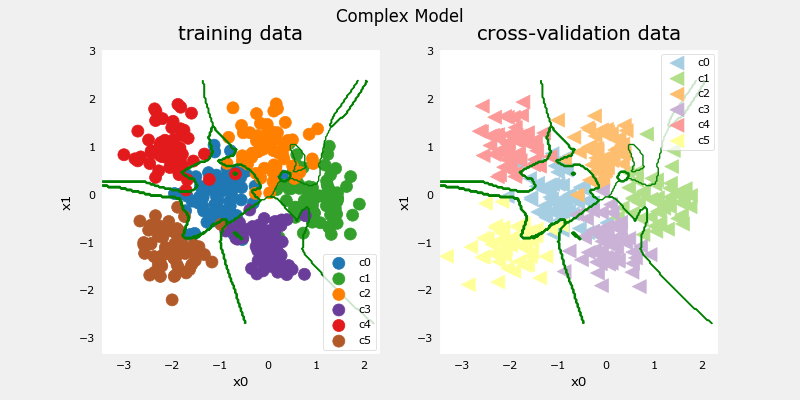

In [34]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [35]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
categorization error, training, complex model: 0.018
categorization error, cv,       complex model: 0.106


<a name="5.1"></a>
### 5.1 Simple model
Now, let's try a simple model

<a name="ex04"></a>
### Exercise 4

Below, compose a two-layer model:
* Dense layer with 6 units, relu activation
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [36]:
# UNQ_C4
# GRADED CELL: model_s

tf.random.set_seed(1234)
model_s = Sequential(
    [
        ### START CODE HERE ### 
        Dense(6, activation = 'relu', name="L1"),
        Dense(classes, activation = 'linear', name="L2")
        ### END CODE HERE ### 
    ], name = "Simple"
)
model_s.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    ### START CODE HERE ### 
)


In [37]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 1.9311
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 1.5857
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 1.3365
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 1.1211
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.9409
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.8049
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.7031
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.6231
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.5562
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4983
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4492
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.4076
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.3735
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.3475
Epoch 15/1000
13/13 ━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1824
Epoch 80/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1821
Epoch 81/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1819
Epoch 82/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1816
Epoch 83/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1814
Epoch 84/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1811
Epoch 85/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1809
Epoch 86/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1807
Epoch 87/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1805
Epoch 88/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1803
Epoch 89/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1800
Epoch 90/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1799
Epoch 91/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1796
Epoch 92/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1795
Epoch 93/1000
13/13 ━━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1730
Epoch 158/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1729
Epoch 159/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1730
Epoch 160/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1730
Epoch 161/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1727
Epoch 162/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1728
Epoch 163/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1726
Epoch 164/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1724
Epoch 165/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1722
Epoch 166/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1721
Epoch 167/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1722
Epoch 168/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1718
Epoch 169/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1718
Epoch 170/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1716
Epoch 171/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1682
Epoch 236/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1679
Epoch 237/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1679
Epoch 238/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1682
Epoch 239/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1678
Epoch 240/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1679
Epoch 241/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1680
Epoch 242/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1676
Epoch 243/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1677
Epoch 244/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1679
Epoch 245/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1676
Epoch 246/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1677
Epoch 247/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1679
Epoch 248/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1675
Epoch 249/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1666
Epoch 314/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1661
Epoch 315/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1663
Epoch 316/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1665
Epoch 317/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1662
Epoch 318/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1663
Epoch 319/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1663
Epoch 320/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1667
Epoch 321/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1662
Epoch 322/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1663
Epoch 323/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1665
Epoch 324/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1659
Epoch 325/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1660
Epoch 326/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1661
Epoch 327/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1659
Epoch 392/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1652
Epoch 393/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1652
Epoch 394/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1653
Epoch 395/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1656
Epoch 396/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1653
Epoch 397/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1656
Epoch 398/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1657
Epoch 399/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1654
Epoch 400/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1656
Epoch 401/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1655
Epoch 402/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1653
Epoch 403/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1652
Epoch 404/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1654
Epoch 405/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1651
Epoch 470/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1652
Epoch 471/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1644
Epoch 472/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1647
Epoch 473/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1648
Epoch 474/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1652
Epoch 475/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1646
Epoch 476/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1649
Epoch 477/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1651
Epoch 478/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1653
Epoch 479/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1645
Epoch 480/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1645
Epoch 481/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1648
Epoch 482/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1651
Epoch 483/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1642
Epoch 548/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1645
Epoch 549/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1646
Epoch 550/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1647
Epoch 551/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1637
Epoch 552/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1641
Epoch 553/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1645
Epoch 554/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1646
Epoch 555/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1641
Epoch 556/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1644
Epoch 557/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1646
Epoch 558/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1648
Epoch 559/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1641
Epoch 560/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1638
Epoch 561/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1640
Epoch 626/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1645
Epoch 627/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1636
Epoch 628/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1634
Epoch 629/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1637
Epoch 630/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1640
Epoch 631/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1638
Epoch 632/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1639
Epoch 633/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1638
Epoch 634/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1641
Epoch 635/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1640
Epoch 636/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1641
Epoch 637/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1639
Epoch 638/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1633
Epoch 639/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1637
Epoch 704/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1634
Epoch 705/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1636
Epoch 706/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1639
Epoch 707/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1639
Epoch 708/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1637
Epoch 709/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1636
Epoch 710/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1635
Epoch 711/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1636
Epoch 712/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1641
Epoch 713/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1634
Epoch 714/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1632
Epoch 715/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1636
Epoch 716/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1637
Epoch 717/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1632
Epoch 782/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1631
Epoch 783/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1636
Epoch 784/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1631
Epoch 785/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1631
Epoch 786/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1634
Epoch 787/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1634
Epoch 788/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1633
Epoch 789/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1632
Epoch 790/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1632
Epoch 791/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1632
Epoch 792/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1634
Epoch 793/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1632
Epoch 794/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.1636
Epoch 795/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1631
Epoch 860/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1630
Epoch 861/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1630
Epoch 862/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1628
Epoch 863/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1628
Epoch 864/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1628
Epoch 865/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1634
Epoch 866/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1628
Epoch 867/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1633
Epoch 868/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1635
Epoch 869/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1633
Epoch 870/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1631
Epoch 871/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1630
Epoch 872/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1630
Epoch 873/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1623
Epoch 938/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.1629
Epoch 939/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1624
Epoch 940/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1626
Epoch 941/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1628
Epoch 942/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1626
Epoch 943/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1625
Epoch 944/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1624
Epoch 945/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1624
Epoch 946/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1624
Epoch 947/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1623
Epoch 948/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1622
Epoch 949/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1627
Epoch 950/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.1625
Epoch 951/1000
13/13 

In [38]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Dense)                      │ (None, 6)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 6)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182 (1.42 KB)

 Trainable params: 60 (480.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 122 (976.00 B)

ValueError: The layer Simple has never been called and thus has no defined input.

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 6)                 18        
_________________________________________________________________
L2 (Dense)                   (None, 6)                 42        
=================================================================
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation = 'relu', name="L1"),            # @REPLACE
        Dense(classes, activation = 'linear', name="L2")     # @REPLACE
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),     # @REPLACE
)

model_s.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step


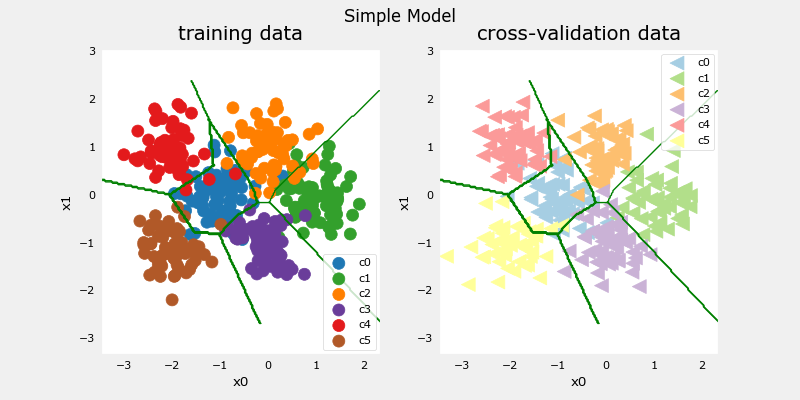

In [39]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

This simple models does pretty well. Let's calculate the classification error.

In [40]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
categorization error, training, simple model, 0.068, complex model: 0.018
categorization error, cv,       simple model, 0.072, complex model: 0.106


Our simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.

<a name="6"></a>
## 6 - Regularization
As in the case of polynomial regression, one can apply regularization to moderate the impact of a more complex model. Let's try this below.

<a name="ex05"></a>
### Exercise 5

Reconstruct your complex model, but this time include regularization.
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 40 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [42]:
# UNQ_C5
# GRADED CELL: model_r

tf.random.set_seed(1234)
model_r = Sequential(
    [
        ### START CODE HERE ### 
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")
        ### START CODE HERE ### 
    ], name= None
)
model_r.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    ### START CODE HERE ### 
)


In [43]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step - loss: 5.9365
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 1.8272
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 1.3860
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 1.1012
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.9974
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.9369
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.8880
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.8559
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 0.8275
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.7941
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.7618
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.7414
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.7283
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.7171
Epoch 15/1000
13/13 ━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4559
Epoch 80/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4547
Epoch 81/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4534
Epoch 82/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4523
Epoch 83/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4510
Epoch 84/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4501
Epoch 85/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4489
Epoch 86/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4479
Epoch 87/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4470
Epoch 88/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4459
Epoch 89/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4450
Epoch 90/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4441
Epoch 91/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4432
Epoch 92/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4425
Epoch 93/1000
13/13 ━━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4293
Epoch 158/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4287
Epoch 159/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4281
Epoch 160/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4275
Epoch 161/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4269
Epoch 162/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4264
Epoch 163/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4258
Epoch 164/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4252
Epoch 165/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4247
Epoch 166/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4241
Epoch 167/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4236
Epoch 168/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4231
Epoch 169/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4226
Epoch 170/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4221
Epoch 171/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3985
Epoch 236/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3982
Epoch 237/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3980
Epoch 238/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3977
Epoch 239/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3975
Epoch 240/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3972
Epoch 241/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3970
Epoch 242/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3967
Epoch 243/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3965
Epoch 244/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3963
Epoch 245/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3960
Epoch 246/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3958
Epoch 247/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3956
Epoch 248/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3954
Epoch 249/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3976
Epoch 314/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3983
Epoch 315/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3991
Epoch 316/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3999
Epoch 317/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4008
Epoch 318/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4018
Epoch 319/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4029
Epoch 320/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4040
Epoch 321/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4052
Epoch 322/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4064
Epoch 323/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4077
Epoch 324/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4091
Epoch 325/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4104
Epoch 326/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4117
Epoch 327/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3767
Epoch 392/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3764
Epoch 393/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3761
Epoch 394/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3757
Epoch 395/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3754
Epoch 396/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3751
Epoch 397/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3747
Epoch 398/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3744
Epoch 399/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3741
Epoch 400/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3738
Epoch 401/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3735
Epoch 402/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3732
Epoch 403/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3729
Epoch 404/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3726
Epoch 405/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3590
Epoch 470/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3589
Epoch 471/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 0.3588
Epoch 472/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3588
Epoch 473/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3587
Epoch 474/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3586
Epoch 475/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3585
Epoch 476/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3585
Epoch 477/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3584
Epoch 478/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.3584
Epoch 479/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.3583
Epoch 480/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3583
Epoch 481/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3583
Epoch 482/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3582
Epoch 483/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3536
Epoch 548/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3536
Epoch 549/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3535
Epoch 550/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3534
Epoch 551/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3533
Epoch 552/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3532
Epoch 553/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3531
Epoch 554/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3530
Epoch 555/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3529
Epoch 556/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3529
Epoch 557/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3528
Epoch 558/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3527
Epoch 559/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3526
Epoch 560/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3525
Epoch 561/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3403
Epoch 626/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3323
Epoch 627/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3419
Epoch 628/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3569
Epoch 629/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3558
Epoch 630/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3668
Epoch 631/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3538
Epoch 632/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3643
Epoch 633/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3634
Epoch 634/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3578
Epoch 635/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3648
Epoch 636/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3644
Epoch 637/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3746
Epoch 638/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3567
Epoch 639/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3388
Epoch 704/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3387
Epoch 705/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3401
Epoch 706/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3416
Epoch 707/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3425
Epoch 708/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3408
Epoch 709/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3319
Epoch 710/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3495
Epoch 711/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3579
Epoch 712/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3555
Epoch 713/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3505
Epoch 714/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3440
Epoch 715/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3339
Epoch 716/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 0.3363
Epoch 717/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3436
Epoch 782/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3439
Epoch 783/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3441
Epoch 784/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3443
Epoch 785/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3445
Epoch 786/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3437
Epoch 787/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3493
Epoch 788/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3550
Epoch 789/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3548
Epoch 790/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3557
Epoch 791/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3530
Epoch 792/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3460
Epoch 793/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3399
Epoch 794/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3376
Epoch 795/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3351
Epoch 860/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3369
Epoch 861/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3386
Epoch 862/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3396
Epoch 863/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3420
Epoch 864/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3372
Epoch 865/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3510
Epoch 866/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3497
Epoch 867/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3466
Epoch 868/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3418
Epoch 869/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3372
Epoch 870/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3346
Epoch 871/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3342
Epoch 872/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3354
Epoch 873/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3387
Epoch 938/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3394
Epoch 939/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3439
Epoch 940/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3466
Epoch 941/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3280
Epoch 942/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3426
Epoch 943/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3449
Epoch 944/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3491
Epoch 945/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3490
Epoch 946/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3356
Epoch 947/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3366
Epoch 948/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3275
Epoch 949/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3370
Epoch 950/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3317
Epoch 951/1000
13/13 

In [44]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Dense)                      │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (127.66 KB)

 Trainable params: 5,446 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (85.11 KB)

ddd


ValueError: The layer sequential has never been called and thus has no defined input.

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "ComplexRegularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")  
    ], name="ComplexRegularized"
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.01),                             
)

model_r.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step


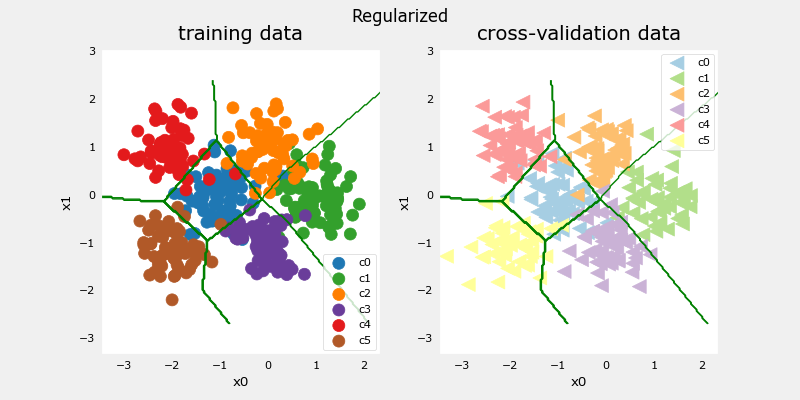

In [45]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

The results look very similar to the 'ideal' model. Let's check classification error.

In [46]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step
categorization error, training, regularized: 0.075, simple model, 0.068, complex model: 0.018
categorization error, cv,       regularized: 0.072, simple model, 0.072, complex model: 0.106


The simple model is a bit better in the training set than the regularized model but it worse in the cross validation set.

<a name="7"></a>
## 7 - Iterate to find optimal regularization value
As you did in linear regression, you can try many regularization values. This code takes several minutes to run. If you have time, you can run it and check the results. If not, you have completed the graded parts of the assignment!

In [47]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - loss: 1.3745
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4413
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3517
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2655
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2331
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2213
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2106
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2038
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2024
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1969
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1940
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1946
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1912
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1912
Epoch 15/1000
13/13 ━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1462
Epoch 80/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1334
Epoch 81/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1377
Epoch 82/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1291
Epoch 83/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1359
Epoch 84/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1293
Epoch 85/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1347
Epoch 86/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1364
Epoch 87/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1281
Epoch 88/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1384
Epoch 89/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1309
Epoch 90/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1391
Epoch 91/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1338
Epoch 92/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1251
Epoch 93/1000
13/13 ━━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0842
Epoch 158/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0929
Epoch 159/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0844
Epoch 160/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1030
Epoch 161/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1019
Epoch 162/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0914
Epoch 163/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0949
Epoch 164/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0842
Epoch 165/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0931
Epoch 166/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0926
Epoch 167/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0946
Epoch 168/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0873
Epoch 169/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0819
Epoch 170/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0915
Epoch 171/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0749
Epoch 236/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0800
Epoch 237/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0754
Epoch 238/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0683
Epoch 239/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0712
Epoch 240/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0724
Epoch 241/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0715
Epoch 242/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0727
Epoch 243/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0637
Epoch 244/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0720
Epoch 245/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0820
Epoch 246/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0673
Epoch 247/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0703
Epoch 248/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0713
Epoch 249/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0560
Epoch 314/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0601
Epoch 315/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0565
Epoch 316/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0658
Epoch 317/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0605
Epoch 318/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0734
Epoch 319/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0598
Epoch 320/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0592
Epoch 321/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0579
Epoch 322/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0536
Epoch 323/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0599
Epoch 324/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0660
Epoch 325/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0559
Epoch 326/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0618
Epoch 327/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0514
Epoch 392/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0532
Epoch 393/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0527
Epoch 394/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0644
Epoch 395/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0490
Epoch 396/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0661
Epoch 397/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0586
Epoch 398/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0550
Epoch 399/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0514
Epoch 400/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0531
Epoch 401/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0626
Epoch 402/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0715
Epoch 403/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0625
Epoch 404/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0562
Epoch 405/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.0584
Epoch 470/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0572
Epoch 471/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0518
Epoch 472/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0499
Epoch 473/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0563
Epoch 474/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0432
Epoch 475/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0449
Epoch 476/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0467
Epoch 477/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0589
Epoch 478/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0452
Epoch 479/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0609
Epoch 480/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0496
Epoch 481/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0489
Epoch 482/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0508
Epoch 483/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0571
Epoch 548/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0615
Epoch 549/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0413
Epoch 550/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0451
Epoch 551/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0424
Epoch 552/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0496
Epoch 553/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0403
Epoch 554/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0416
Epoch 555/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0383
Epoch 556/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0373
Epoch 557/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0398
Epoch 558/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0610
Epoch 559/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0487
Epoch 560/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0691
Epoch 561/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0744
Epoch 626/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0671
Epoch 627/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0673
Epoch 628/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0687
Epoch 629/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0660
Epoch 630/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0606
Epoch 631/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0553
Epoch 632/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0549
Epoch 633/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0531
Epoch 634/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0400
Epoch 635/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0426
Epoch 636/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0357
Epoch 637/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0349
Epoch 638/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0374
Epoch 639/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1875
Epoch 704/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1136
Epoch 705/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1857
Epoch 706/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1387
Epoch 707/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0989
Epoch 708/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0732
Epoch 709/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0862
Epoch 710/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0729
Epoch 711/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0586
Epoch 712/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0660
Epoch 713/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0567
Epoch 714/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0629
Epoch 715/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0614
Epoch 716/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0627
Epoch 717/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0467
Epoch 782/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0426
Epoch 783/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0360
Epoch 784/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0490
Epoch 785/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0381
Epoch 786/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0736
Epoch 787/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0587
Epoch 788/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0556
Epoch 789/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0680
Epoch 790/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0729
Epoch 791/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0493
Epoch 792/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0715
Epoch 793/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0415
Epoch 794/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0704
Epoch 795/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0190
Epoch 860/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0278
Epoch 861/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0258
Epoch 862/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0209
Epoch 863/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0174
Epoch 864/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0276
Epoch 865/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0576
Epoch 866/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0202
Epoch 867/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0240
Epoch 868/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0180
Epoch 869/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0161
Epoch 870/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0123
Epoch 871/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0144
Epoch 872/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0115
Epoch 873/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0182
Epoch 938/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0190
Epoch 939/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0179
Epoch 940/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0190
Epoch 941/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0182
Epoch 942/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0198
Epoch 943/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0169
Epoch 944/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0198
Epoch 945/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0169
Epoch 946/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0183
Epoch 947/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0170
Epoch 948/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0194
Epoch 949/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0164
Epoch 950/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.0193
Epoch 951/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2497
Epoch 16/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2490
Epoch 17/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2477
Epoch 18/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2467
Epoch 19/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2445
Epoch 20/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2477
Epoch 21/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2400
Epoch 22/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2392
Epoch 23/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2409
Epoch 24/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2374
Epoch 25/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2346
Epoch 26/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2334
Epoch 27/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2331
Epoch 28/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2351
Epoch 29/1000
13/13 ━━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2030
Epoch 94/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1999
Epoch 95/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2070
Epoch 96/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2037
Epoch 97/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2018
Epoch 98/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2045
Epoch 99/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2023
Epoch 100/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1980
Epoch 101/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2047
Epoch 102/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1959
Epoch 103/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2007
Epoch 104/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1979
Epoch 105/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2059
Epoch 106/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1979
Epoch 107/1000
13/13 ━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1823
Epoch 172/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1850
Epoch 173/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1853
Epoch 174/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1837
Epoch 175/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1867
Epoch 176/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1828
Epoch 177/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1832
Epoch 178/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1838
Epoch 179/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1834
Epoch 180/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1829
Epoch 181/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1857
Epoch 182/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1854
Epoch 183/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1801
Epoch 184/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1799
Epoch 185/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1697
Epoch 250/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1768
Epoch 251/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1697
Epoch 252/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1754
Epoch 253/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1722
Epoch 254/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1748
Epoch 255/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1694
Epoch 256/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1798
Epoch 257/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1651
Epoch 258/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1785
Epoch 259/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1702
Epoch 260/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1772
Epoch 261/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1693
Epoch 262/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1782
Epoch 263/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1667
Epoch 328/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1655
Epoch 329/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1681
Epoch 330/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1721
Epoch 331/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1666
Epoch 332/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1740
Epoch 333/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1609
Epoch 334/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1726
Epoch 335/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1608
Epoch 336/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1723
Epoch 337/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1580
Epoch 338/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1759
Epoch 339/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 0.1594
Epoch 340/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1742
Epoch 341/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1616
Epoch 406/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1697
Epoch 407/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1619
Epoch 408/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1657
Epoch 409/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1672
Epoch 410/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1574
Epoch 411/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1716
Epoch 412/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1606
Epoch 413/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1588
Epoch 414/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1640
Epoch 415/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1585
Epoch 416/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1620
Epoch 417/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1595
Epoch 418/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1584
Epoch 419/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1549
Epoch 484/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1525
Epoch 485/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1576
Epoch 486/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1521
Epoch 487/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1635
Epoch 488/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1532
Epoch 489/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1671
Epoch 490/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1529
Epoch 491/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1562
Epoch 492/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1661
Epoch 493/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1556
Epoch 494/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1602
Epoch 495/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1575
Epoch 496/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1601
Epoch 497/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1468
Epoch 562/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1512
Epoch 563/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1462
Epoch 564/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1484
Epoch 565/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1545
Epoch 566/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1480
Epoch 567/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1558
Epoch 568/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1520
Epoch 569/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1519
Epoch 570/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1603
Epoch 571/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1509
Epoch 572/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1663
Epoch 573/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1510
Epoch 574/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1628
Epoch 575/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1499
Epoch 640/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1484
Epoch 641/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1500
Epoch 642/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1469
Epoch 643/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1450
Epoch 644/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1485
Epoch 645/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1438
Epoch 646/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1501
Epoch 647/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1467
Epoch 648/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1530
Epoch 649/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1456
Epoch 650/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1440
Epoch 651/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1526
Epoch 652/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1450
Epoch 653/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1455
Epoch 718/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1454
Epoch 719/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1462
Epoch 720/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1404
Epoch 721/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1412
Epoch 722/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1421
Epoch 723/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1438
Epoch 724/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1451
Epoch 725/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1402
Epoch 726/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1471
Epoch 727/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1411
Epoch 728/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1490
Epoch 729/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1406
Epoch 730/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.1541
Epoch 731/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1409
Epoch 796/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1419
Epoch 797/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1442
Epoch 798/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1408
Epoch 799/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1451
Epoch 800/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1425
Epoch 801/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1536
Epoch 802/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1463
Epoch 803/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1450
Epoch 804/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1427
Epoch 805/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1444
Epoch 806/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1401
Epoch 807/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1410
Epoch 808/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1351
Epoch 809/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1424
Epoch 874/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1406
Epoch 875/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1404
Epoch 876/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1367
Epoch 877/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1351
Epoch 878/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1356
Epoch 879/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1354
Epoch 880/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1361
Epoch 881/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1358
Epoch 882/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1349
Epoch 883/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1334
Epoch 884/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1447
Epoch 885/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1416
Epoch 886/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1635
Epoch 887/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1512
Epoch 952/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1295
Epoch 953/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1358
Epoch 954/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1301
Epoch 955/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1416
Epoch 956/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1323
Epoch 957/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1346
Epoch 958/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1252
Epoch 959/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1368
Epoch 960/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1273
Epoch 961/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1371
Epoch 962/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1320
Epoch 963/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1441
Epoch 964/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1332
Epoch 965/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3510
Epoch 30/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3469
Epoch 31/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3446
Epoch 32/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3465
Epoch 33/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3444
Epoch 34/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3399
Epoch 35/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3362
Epoch 36/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3331
Epoch 37/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3333
Epoch 38/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3288
Epoch 39/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3287
Epoch 40/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3253
Epoch 41/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3248
Epoch 42/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3232
Epoch 43/1000
13/13 ━━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2716
Epoch 108/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2710
Epoch 109/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2730
Epoch 110/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2693
Epoch 111/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2703
Epoch 112/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2695
Epoch 113/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2687
Epoch 114/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2705
Epoch 115/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2681
Epoch 116/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2661
Epoch 117/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2678
Epoch 118/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2649
Epoch 119/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2667
Epoch 120/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2664
Epoch 121/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2543
Epoch 186/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.2545
Epoch 187/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2550
Epoch 188/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2523
Epoch 189/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2528
Epoch 190/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2524
Epoch 191/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2522
Epoch 192/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2521
Epoch 193/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2515
Epoch 194/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2511
Epoch 195/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2513
Epoch 196/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2510
Epoch 197/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2502
Epoch 198/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2510
Epoch 199/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2450
Epoch 264/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2446
Epoch 265/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2438
Epoch 266/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2433
Epoch 267/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2451
Epoch 268/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2421
Epoch 269/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2442
Epoch 270/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2423
Epoch 271/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2424
Epoch 272/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2437
Epoch 273/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2428
Epoch 274/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2434
Epoch 275/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2428
Epoch 276/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2414
Epoch 277/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2357
Epoch 342/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2369
Epoch 343/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2344
Epoch 344/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2367
Epoch 345/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2370
Epoch 346/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2356
Epoch 347/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2354
Epoch 348/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2370
Epoch 349/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2314
Epoch 350/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2379
Epoch 351/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2338
Epoch 352/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2369
Epoch 353/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2339
Epoch 354/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2360
Epoch 355/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2320
Epoch 420/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2296
Epoch 421/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2293
Epoch 422/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2302
Epoch 423/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2300
Epoch 424/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2294
Epoch 425/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2313
Epoch 426/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2301
Epoch 427/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2284
Epoch 428/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2302
Epoch 429/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2270
Epoch 430/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2293
Epoch 431/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2303
Epoch 432/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2281
Epoch 433/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2261
Epoch 498/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2240
Epoch 499/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2247
Epoch 500/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2237
Epoch 501/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2248
Epoch 502/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2257
Epoch 503/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2227
Epoch 504/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2251
Epoch 505/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2239
Epoch 506/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2254
Epoch 507/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2260
Epoch 508/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2228
Epoch 509/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2237
Epoch 510/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2235
Epoch 511/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2207
Epoch 576/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2221
Epoch 577/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2181
Epoch 578/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2188
Epoch 579/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2201
Epoch 580/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2198
Epoch 581/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2183
Epoch 582/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2184
Epoch 583/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2207
Epoch 584/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2195
Epoch 585/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2178
Epoch 586/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2200
Epoch 587/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2194
Epoch 588/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2188
Epoch 589/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2156
Epoch 654/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2180
Epoch 655/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2168
Epoch 656/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2150
Epoch 657/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2154
Epoch 658/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2178
Epoch 659/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2154
Epoch 660/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2225
Epoch 661/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2146
Epoch 662/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2181
Epoch 663/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2190
Epoch 664/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2156
Epoch 665/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2158
Epoch 666/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2162
Epoch 667/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2154
Epoch 732/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2149
Epoch 733/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2166
Epoch 734/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2142
Epoch 735/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2142
Epoch 736/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2148
Epoch 737/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2141
Epoch 738/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2143
Epoch 739/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2152
Epoch 740/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2155
Epoch 741/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2151
Epoch 742/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2128
Epoch 743/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2161
Epoch 744/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2187
Epoch 745/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2124
Epoch 810/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2129
Epoch 811/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2121
Epoch 812/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2135
Epoch 813/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2146
Epoch 814/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2118
Epoch 815/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2136
Epoch 816/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2134
Epoch 817/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2181
Epoch 818/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2270
Epoch 819/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2385
Epoch 820/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2180
Epoch 821/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2174
Epoch 822/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2140
Epoch 823/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2106
Epoch 888/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2114
Epoch 889/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2099
Epoch 890/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2087
Epoch 891/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2114
Epoch 892/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2075
Epoch 893/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2121
Epoch 894/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2098
Epoch 895/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2112
Epoch 896/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2103
Epoch 897/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2108
Epoch 898/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2135
Epoch 899/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2086
Epoch 900/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2116
Epoch 901/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2097
Epoch 966/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2094
Epoch 967/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2125
Epoch 968/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2079
Epoch 969/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2092
Epoch 970/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2095
Epoch 971/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2076
Epoch 972/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2086
Epoch 973/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2080
Epoch 974/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2099
Epoch 975/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2070
Epoch 976/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2073
Epoch 977/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2134
Epoch 978/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2104
Epoch 979/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4226
Epoch 44/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4214
Epoch 45/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4182
Epoch 46/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4172
Epoch 47/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4149
Epoch 48/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4128
Epoch 49/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4118
Epoch 50/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4095
Epoch 51/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4087
Epoch 52/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4069
Epoch 53/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4063
Epoch 54/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4052
Epoch 55/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4049
Epoch 56/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4045
Epoch 57/1000
13/13 ━━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3862
Epoch 122/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3845
Epoch 123/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3829
Epoch 124/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3815
Epoch 125/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3803
Epoch 126/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3792
Epoch 127/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3772
Epoch 128/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3761
Epoch 129/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3743
Epoch 130/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3729
Epoch 131/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3708
Epoch 132/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3685
Epoch 133/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3658
Epoch 134/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3638
Epoch 135/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3291
Epoch 200/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3284
Epoch 201/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3278
Epoch 202/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3279
Epoch 203/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3277
Epoch 204/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3274
Epoch 205/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3269
Epoch 206/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3267
Epoch 207/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3264
Epoch 208/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3262
Epoch 209/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3255
Epoch 210/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3252
Epoch 211/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3252
Epoch 212/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3245
Epoch 213/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3116
Epoch 278/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3110
Epoch 279/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3115
Epoch 280/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3116
Epoch 281/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3109
Epoch 282/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3114
Epoch 283/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3105
Epoch 284/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3113
Epoch 285/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3104
Epoch 286/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3104
Epoch 287/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3096
Epoch 288/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3094
Epoch 289/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3096
Epoch 290/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3097
Epoch 291/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3008
Epoch 356/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3003
Epoch 357/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3000
Epoch 358/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3000
Epoch 359/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3002
Epoch 360/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2997
Epoch 361/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2995
Epoch 362/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2994
Epoch 363/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2992
Epoch 364/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2997
Epoch 365/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2988
Epoch 366/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2991
Epoch 367/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2992
Epoch 368/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2994
Epoch 369/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2925
Epoch 434/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2921
Epoch 435/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2925
Epoch 436/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2917
Epoch 437/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2923
Epoch 438/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2913
Epoch 439/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2923
Epoch 440/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2917
Epoch 441/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2918
Epoch 442/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2914
Epoch 443/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2919
Epoch 444/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2913
Epoch 445/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2912
Epoch 446/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2911
Epoch 447/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2867
Epoch 512/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2856
Epoch 513/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2864
Epoch 514/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2853
Epoch 515/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2859
Epoch 516/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2853
Epoch 517/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2858
Epoch 518/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2853
Epoch 519/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2860
Epoch 520/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2853
Epoch 521/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2862
Epoch 522/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2857
Epoch 523/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2861
Epoch 524/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2848
Epoch 525/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2823
Epoch 590/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2951
Epoch 591/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2865
Epoch 592/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2904
Epoch 593/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2833
Epoch 594/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2810
Epoch 595/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2802
Epoch 596/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2853
Epoch 597/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2882
Epoch 598/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2922
Epoch 599/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2869
Epoch 600/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2815
Epoch 601/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2797
Epoch 602/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2805
Epoch 603/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2768
Epoch 668/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2780
Epoch 669/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2781
Epoch 670/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2778
Epoch 671/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2784
Epoch 672/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2778
Epoch 673/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2795
Epoch 674/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2771
Epoch 675/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2785
Epoch 676/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2776
Epoch 677/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2773
Epoch 678/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2779
Epoch 679/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2774
Epoch 680/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2771
Epoch 681/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2748
Epoch 746/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2737
Epoch 747/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2752
Epoch 748/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2747
Epoch 749/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2772
Epoch 750/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2746
Epoch 751/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2738
Epoch 752/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2922
Epoch 753/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2804
Epoch 754/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2871
Epoch 755/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2766
Epoch 756/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2741
Epoch 757/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2704
Epoch 758/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2736
Epoch 759/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2731
Epoch 824/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2750
Epoch 825/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2739
Epoch 826/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2751
Epoch 827/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2734
Epoch 828/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2707
Epoch 829/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2716
Epoch 830/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2716
Epoch 831/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2725
Epoch 832/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2757
Epoch 833/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2714
Epoch 834/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2715
Epoch 835/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2715
Epoch 836/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2755
Epoch 837/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2700
Epoch 902/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2691
Epoch 903/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2703
Epoch 904/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2695
Epoch 905/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2692
Epoch 906/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2693
Epoch 907/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2686
Epoch 908/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2695
Epoch 909/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2704
Epoch 910/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2694
Epoch 911/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2691
Epoch 912/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2704
Epoch 913/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2665
Epoch 914/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2695
Epoch 915/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2705
Epoch 980/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2698
Epoch 981/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2671
Epoch 982/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2637
Epoch 983/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2681
Epoch 984/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2647
Epoch 985/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2652
Epoch 986/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2660
Epoch 987/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2662
Epoch 988/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2658
Epoch 989/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2699
Epoch 990/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2676
Epoch 991/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.2671
Epoch 992/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.2680
Epoch 993/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4835
Epoch 58/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4818
Epoch 59/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4796
Epoch 60/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4775
Epoch 61/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4755
Epoch 62/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4738
Epoch 63/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4718
Epoch 64/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4700
Epoch 65/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4680
Epoch 66/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4667
Epoch 67/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4648
Epoch 68/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4634
Epoch 69/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4617
Epoch 70/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4605
Epoch 71/1000
13/13 ━━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4359
Epoch 136/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4360
Epoch 137/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4347
Epoch 138/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4340
Epoch 139/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4341
Epoch 140/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4336
Epoch 141/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4322
Epoch 142/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4323
Epoch 143/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4319
Epoch 144/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4314
Epoch 145/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4305
Epoch 146/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4301
Epoch 147/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4302
Epoch 148/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4294
Epoch 149/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4052
Epoch 214/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4048
Epoch 215/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4040
Epoch 216/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4035
Epoch 217/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4024
Epoch 218/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4025
Epoch 219/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4009
Epoch 220/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4008
Epoch 221/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4001
Epoch 222/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3990
Epoch 223/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3992
Epoch 224/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3978
Epoch 225/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3972
Epoch 226/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3972
Epoch 227/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3728
Epoch 292/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3726
Epoch 293/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3723
Epoch 294/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3721
Epoch 295/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3718
Epoch 296/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3715
Epoch 297/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3712
Epoch 298/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3710
Epoch 299/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3708
Epoch 300/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3706
Epoch 301/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3704
Epoch 302/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3696
Epoch 303/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3694
Epoch 304/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3695
Epoch 305/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3556
Epoch 370/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3553
Epoch 371/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3546
Epoch 372/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3552
Epoch 373/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3548
Epoch 374/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3542
Epoch 375/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3543
Epoch 376/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3542
Epoch 377/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3542
Epoch 378/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3538
Epoch 379/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3534
Epoch 380/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3533
Epoch 381/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3536
Epoch 382/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3532
Epoch 383/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3444
Epoch 448/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3441
Epoch 449/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3435
Epoch 450/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3440
Epoch 451/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3433
Epoch 452/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3435
Epoch 453/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3438
Epoch 454/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3434
Epoch 455/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3427
Epoch 456/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3433
Epoch 457/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3426
Epoch 458/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3428
Epoch 459/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3431
Epoch 460/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3429
Epoch 461/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3388
Epoch 526/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3340
Epoch 527/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3318
Epoch 528/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3321
Epoch 529/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3332
Epoch 530/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3341
Epoch 531/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3343
Epoch 532/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3344
Epoch 533/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3348
Epoch 534/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3348
Epoch 535/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3339
Epoch 536/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3342
Epoch 537/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3343
Epoch 538/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3340
Epoch 539/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3353
Epoch 604/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3311
Epoch 605/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3272
Epoch 606/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3255
Epoch 607/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3250
Epoch 608/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3264
Epoch 609/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3265
Epoch 610/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3271
Epoch 611/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3277
Epoch 612/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3277
Epoch 613/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3275
Epoch 614/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3276
Epoch 615/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3269
Epoch 616/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3267
Epoch 617/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3247
Epoch 682/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3245
Epoch 683/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3251
Epoch 684/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3190
Epoch 685/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3269
Epoch 686/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3191
Epoch 687/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3331
Epoch 688/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3304
Epoch 689/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3318
Epoch 690/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3278
Epoch 691/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3256
Epoch 692/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3229
Epoch 693/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3221
Epoch 694/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3220
Epoch 695/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3220
Epoch 760/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3178
Epoch 761/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3335
Epoch 762/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3337
Epoch 763/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3294
Epoch 764/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3329
Epoch 765/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3688
Epoch 766/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3375
Epoch 767/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3380
Epoch 768/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3298
Epoch 769/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3250
Epoch 770/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3174
Epoch 771/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3327
Epoch 772/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3335
Epoch 773/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3151
Epoch 838/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3169
Epoch 839/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3158
Epoch 840/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3172
Epoch 841/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3150
Epoch 842/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3165
Epoch 843/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3148
Epoch 844/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3160
Epoch 845/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3160
Epoch 846/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3160
Epoch 847/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3151
Epoch 848/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3162
Epoch 849/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3163
Epoch 850/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3172
Epoch 851/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3156
Epoch 916/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3190
Epoch 917/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3215
Epoch 918/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3239
Epoch 919/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3433
Epoch 920/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3303
Epoch 921/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3292
Epoch 922/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3245
Epoch 923/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3202
Epoch 924/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3159
Epoch 925/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3115
Epoch 926/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3104
Epoch 927/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3088
Epoch 928/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3112
Epoch 929/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3106
Epoch 994/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3098
Epoch 995/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3089
Epoch 996/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3099
Epoch 997/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3101
Epoch 998/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3102
Epoch 999/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3086
Epoch 1000/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3099
Finished lambda = 0.1
Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step - loss: 10.2004
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 2.1694
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 1.8085
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 1.4370
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 1.2687
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 1.1856
Epoch 7/1

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5851
Epoch 72/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5829
Epoch 73/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.5808
Epoch 74/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5787
Epoch 75/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5767
Epoch 76/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5747
Epoch 77/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5727
Epoch 78/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5708
Epoch 79/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5688
Epoch 80/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5670
Epoch 81/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5651
Epoch 82/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5634
Epoch 83/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5616
Epoch 84/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5598
Epoch 85/1000
13/13 ━━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4871
Epoch 150/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4864
Epoch 151/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4857
Epoch 152/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4849
Epoch 153/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4842
Epoch 154/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4835
Epoch 155/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4828
Epoch 156/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4821
Epoch 157/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4814
Epoch 158/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4807
Epoch 159/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4800
Epoch 160/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4793
Epoch 161/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4787
Epoch 162/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4780
Epoch 163/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4445
Epoch 228/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4441
Epoch 229/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4437
Epoch 230/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4433
Epoch 231/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4429
Epoch 232/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4426
Epoch 233/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4422
Epoch 234/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4418
Epoch 235/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4415
Epoch 236/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4411
Epoch 237/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4408
Epoch 238/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4404
Epoch 239/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4401
Epoch 240/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4398
Epoch 241/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4780
Epoch 306/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4769
Epoch 307/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4756
Epoch 308/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4742
Epoch 309/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4728
Epoch 310/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4717
Epoch 311/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4707
Epoch 312/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4698
Epoch 313/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4692
Epoch 314/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4685
Epoch 315/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4679
Epoch 316/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4673
Epoch 317/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4667
Epoch 318/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4660
Epoch 319/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4411
Epoch 384/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4409
Epoch 385/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4406
Epoch 386/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.4404
Epoch 387/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4401
Epoch 388/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4399 
Epoch 389/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.4397
Epoch 390/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4394
Epoch 391/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4392
Epoch 392/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4390
Epoch 393/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4387
Epoch 394/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.4385
Epoch 395/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4383
Epoch 396/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4381
Epoch 397/1000
13/13 ━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4262
Epoch 462/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4260
Epoch 463/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4259
Epoch 464/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4257
Epoch 465/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4256
Epoch 466/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4254
Epoch 467/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4253
Epoch 468/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4251
Epoch 469/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4250
Epoch 470/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4248
Epoch 471/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4246
Epoch 472/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4245
Epoch 473/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4243
Epoch 474/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4242
Epoch 475/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4154
Epoch 540/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4154
Epoch 541/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4155
Epoch 542/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4155
Epoch 543/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4155
Epoch 544/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4154
Epoch 545/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4153
Epoch 546/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4152
Epoch 547/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4151
Epoch 548/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4149
Epoch 549/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4147
Epoch 550/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4146
Epoch 551/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4144
Epoch 552/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4143
Epoch 553/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4074
Epoch 618/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4073
Epoch 619/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4072
Epoch 620/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4071
Epoch 621/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4069
Epoch 622/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4070
Epoch 623/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4087
Epoch 624/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4003
Epoch 625/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3997
Epoch 626/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4062
Epoch 627/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4091
Epoch 628/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4098
Epoch 629/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4084
Epoch 630/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4097
Epoch 631/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3900
Epoch 696/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4093
Epoch 697/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4176
Epoch 698/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4133
Epoch 699/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3838
Epoch 700/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3788
Epoch 701/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3923
Epoch 702/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3976
Epoch 703/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4048
Epoch 704/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4096
Epoch 705/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4114
Epoch 706/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4123
Epoch 707/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4115
Epoch 708/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4097
Epoch 709/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3959
Epoch 774/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4078
Epoch 775/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4101
Epoch 776/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4014
Epoch 777/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4047
Epoch 778/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3960
Epoch 779/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3951
Epoch 780/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3960
Epoch 781/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3943
Epoch 782/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3955
Epoch 783/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3945
Epoch 784/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3948
Epoch 785/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3945
Epoch 786/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3944
Epoch 787/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3877
Epoch 852/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3876
Epoch 853/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3914
Epoch 854/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3911
Epoch 855/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3917
Epoch 856/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3915
Epoch 857/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3907
Epoch 858/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3925
Epoch 859/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4164
Epoch 860/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4094
Epoch 861/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3890
Epoch 862/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3915
Epoch 863/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3894
Epoch 864/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3882
Epoch 865/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3843
Epoch 930/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3842
Epoch 931/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3841
Epoch 932/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3840
Epoch 933/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3839
Epoch 934/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3838
Epoch 935/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3837
Epoch 936/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3836
Epoch 937/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 0.3835
Epoch 938/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3834
Epoch 939/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.3833
Epoch 940/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3858
Epoch 941/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3894
Epoch 942/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3922
Epoch 943/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 1.4232
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 1.3801
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 1.3297
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 1.2695
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 1.2128
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 1.1743
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 1.1354
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 1.1060
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 1.0807
Epoch 16/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 1.0587
Epoch 17/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 1.0405
Epoch 18/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 1.0235
Epoch 19/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 1.0075
Epoch 20/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.9918
Epoch 21/1000
13/13 ━━━━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.6584
Epoch 86/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.6564
Epoch 87/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.6544
Epoch 88/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.6524
Epoch 89/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.6505
Epoch 90/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.6486
Epoch 91/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.6467
Epoch 92/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.6449
Epoch 93/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.6431
Epoch 94/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.6413
Epoch 95/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.6395
Epoch 96/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.6378
Epoch 97/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.6361
Epoch 98/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.6344
Epoch 99/1000
13/13 ━━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5579
Epoch 164/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5570
Epoch 165/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5563
Epoch 166/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5554
Epoch 167/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5546
Epoch 168/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5537
Epoch 169/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.5530
Epoch 170/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5522
Epoch 171/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5514
Epoch 172/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5506
Epoch 173/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5498
Epoch 174/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5490
Epoch 175/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5482
Epoch 176/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5475
Epoch 177/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5076
Epoch 242/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5072
Epoch 243/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5067
Epoch 244/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5062
Epoch 245/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5057
Epoch 246/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5052
Epoch 247/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5047
Epoch 248/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5042
Epoch 249/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5038
Epoch 250/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5033
Epoch 251/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5028
Epoch 252/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.5024
Epoch 253/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5019
Epoch 254/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5014
Epoch 255/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4753
Epoch 320/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4750
Epoch 321/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4746
Epoch 322/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4743
Epoch 323/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4739
Epoch 324/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4736
Epoch 325/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4732
Epoch 326/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4730
Epoch 327/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4725
Epoch 328/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4723
Epoch 329/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4719
Epoch 330/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4716
Epoch 331/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4712
Epoch 332/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4709
Epoch 333/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4520
Epoch 398/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4518
Epoch 399/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4515
Epoch 400/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4513
Epoch 401/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4510
Epoch 402/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4508
Epoch 403/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4505
Epoch 404/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4503
Epoch 405/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4500
Epoch 406/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4498
Epoch 407/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4496
Epoch 408/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4493
Epoch 409/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4491
Epoch 410/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4488
Epoch 411/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4357
Epoch 476/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4355
Epoch 477/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4353
Epoch 478/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4351
Epoch 479/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4349
Epoch 480/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4348
Epoch 481/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4346
Epoch 482/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4344
Epoch 483/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4343
Epoch 484/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4341
Epoch 485/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4339
Epoch 486/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4338
Epoch 487/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4335
Epoch 488/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4333
Epoch 489/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4262
Epoch 554/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4261
Epoch 555/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4261
Epoch 556/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4259
Epoch 557/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4260
Epoch 558/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4258
Epoch 559/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4258
Epoch 560/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4257
Epoch 561/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4256
Epoch 562/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4256
Epoch 563/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4255
Epoch 564/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4255
Epoch 565/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4254
Epoch 566/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4255
Epoch 567/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4445
Epoch 632/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4478
Epoch 633/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4452
Epoch 634/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4506
Epoch 635/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4513
Epoch 636/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4526
Epoch 637/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4564
Epoch 638/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4623
Epoch 639/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4695
Epoch 640/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4798
Epoch 641/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4512
Epoch 642/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4588
Epoch 643/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4608
Epoch 644/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4399
Epoch 645/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4744
Epoch 710/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4726
Epoch 711/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4644
Epoch 712/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4405
Epoch 713/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4379
Epoch 714/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4578
Epoch 715/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4414
Epoch 716/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4254
Epoch 717/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4389
Epoch 718/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4653
Epoch 719/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4815
Epoch 720/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4956
Epoch 721/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5048
Epoch 722/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.5057
Epoch 723/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.4474
Epoch 788/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4548
Epoch 789/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4589
Epoch 790/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4625
Epoch 791/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4630
Epoch 792/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4800
Epoch 793/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4644
Epoch 794/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4571
Epoch 795/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4541
Epoch 796/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4529
Epoch 797/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4517
Epoch 798/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4518
Epoch 799/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4514
Epoch 800/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4514
Epoch 801/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4398
Epoch 866/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4231
Epoch 867/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4224
Epoch 868/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4452
Epoch 869/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4487
Epoch 870/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4613
Epoch 871/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4617
Epoch 872/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4621
Epoch 873/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4579
Epoch 874/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4536
Epoch 875/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4485
Epoch 876/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4442
Epoch 877/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4411
Epoch 878/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4397
Epoch 879/1000
13/13 

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4437
Epoch 944/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4401
Epoch 945/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4375
Epoch 946/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4358
Epoch 947/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4350
Epoch 948/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4369
Epoch 949/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4352
Epoch 950/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4260
Epoch 951/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4327
Epoch 952/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4367
Epoch 953/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4428
Epoch 954/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4436
Epoch 955/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.4049
Epoch 956/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.4219
Epoch 957/1000
13/13 

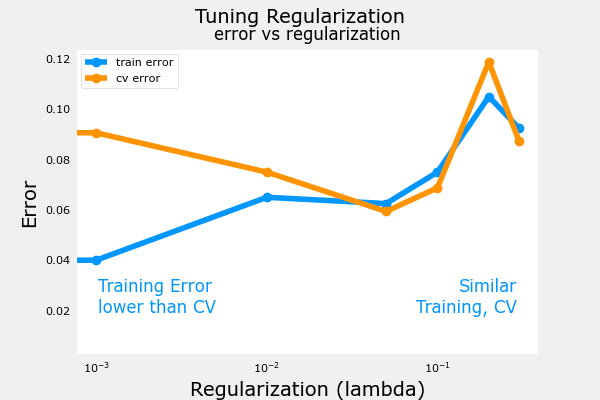

In [48]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.

<a name="7.1"></a>
### 7.1 Test
Let's try our optimized models on the test set and compare them to 'ideal' performance. 

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


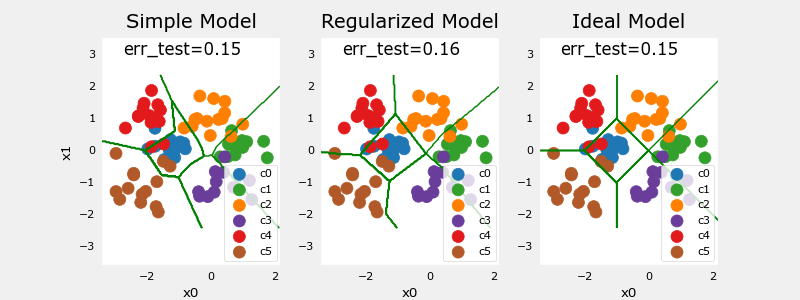

In [49]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

Our test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.

## Congratulations! 
You have become familiar with important tools to apply when evaluating your machine learning models. Namely:  
* splitting data into trained and untrained sets allows you to differentiate between underfitting and overfitting
* creating three data sets, Training, Cross-Validation and Test allows you to
    * train your parameters $W,B$ with the training set
    * tune model parameters such as complexity, regularization and number of examples with the cross-validation set
    * evaluate your 'real world' performance using the test set.
* comparing training vs cross-validation performance provides insight into a model's propensity towards overfitting (high variance) or underfitting (high bias)